# Create, evaluate, and score a churn prediction model

## Introduction

In this notebook, you'll see a Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

The main steps in this notebook are:

1. Install custom libraries
2. Load the data
3. Understand and process the data through exploratory data analysis and demonstrate the use of Fabric Data Wrangler feature
4. Train machine learning models using `Scikit-Learn`, and track experiments using MLflow and Fabric Autologging feature
5. Evaluate and save the final machine learning model

## Step 1: Install custom libraries


For this notebook, you'll install the `imblearn` using `%pip install`. Note that the PySpark kernel will be restarted after `%pip install`, thus you'll need to install the library before you run any other cells.

In [1]:
# Use pip to install imblearn for SMOTE
%pip install imblearn

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 8, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 16.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



## Step 2: Load the data

### Dataset

The dataset contains churn status of 10,000 customers along with 14 attributes that include credit score, geographical location (Germany, France, Spain), gender (male, female), age, tenure (years of being bank's customer), account balance, estimated salary, number of products that a customer has purchased through the bank, credit card status (whether a customer has a credit card or not), and active member status (whether an active bank's customer or not).

The dataset also includes columns such as row number, customer ID, and customer surname that should have no impact on customer's decision to leave the bank. The event that defines the customer's churn is the closing of the customer's bank account, therefore, the column `exit` in the dataset refers to customer's abandonment. Since you don't have much context about these attributes, you'll proceed without having background information about the dataset. Your aim is to understand how these attributes contribute to the `exit` status.

Out of the 10,000 customers, only 2037 customers (around 20%) have left the bank. Therefore, given the class imbalance ratio, it is recommended to generate synthetic data.

- churn.csv

|"CustomerID"|"Surname"|"CreditScore"|"Geography"|"Gender"|"Age"|"Tenure"|"Balance"|"NumOfProducts"|"HasCrCard"|"IsActiveMember"|"EstimatedSalary"|"Exited"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|15634602|Hargrave|619|France|Female|42|2|0.00|1|1|1|101348.88|1|
|15647311|Hill|608|Spain|Female|41|1|83807.86|1|0|1|112542.58|0|




### Introduction to SMOTE

The problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. Synthetic Minority Oversampling Technique (SMOTE) is the most widely used approach to synthesize new samples for the minority class. Learn more about SMOTE [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#) and [here](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn).

You will be able to access SMOTE using the `imblearn` library that you installed in Step 1.

In [7]:
IS_CUSTOM_DATA = False  # if TRUE, dataset has to be uploaded manually

IS_SAMPLE = False  # if TRUE, use only SAMPLE_ROWS of data for training, otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training

DATA_ROOT = "/lakehouse/default"
DATA_FOLDER = "Files/churn"  # folder with data files
DATA_FILE = "churn.csv"  # data file name

StatementMeta(, c65ed53f-69cb-4e34-b20a-3ecfdbbe3ce4, 21, Finished, Available, Finished)

Start recording the time it takes to run this notebook.

In [3]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 11, Finished, Available, Finished)

### Read raw data from the lakehouse

Reads raw data from the **Files** section of the lakehouse, adds additional columns for different date parts and the same information will be used to create partitioned delta table.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import coalesce,concat_ws
from pyspark.sql import functions as F
from pyspark.sql.types import StringType


# Initialize Spark session (if not already initialized)
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.caseSensitive", "true")
df=spark.table("customer_churn")

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 12, Finished, Available, Finished)

In [5]:
display(df, summary=True)

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 0df495ca-2d99-4fbd-9854-daf450947478)

### Create a pandas dataframe from the dataset

This code converts the spark DataFrame to pandas DataFrame for easier processing and visualization.

In [6]:
df = df.toPandas()

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 14, Finished, Available, Finished)

## Step 3: Exploratory Data Analysis

### Display raw data

Explore the raw data with `display`, do some basic statistics and show chart views. You first need to import required libraries for data visualization such as `seaborn` which is a Python data visualization library to provide a high-level interface for building visuals on dataframes and arrays. Learn more about [`seaborn`](https://seaborn.pydata.org/). 

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 15, Finished, Available, Finished)

### Use Data Wrangler to perform initial data cleansing

Launch Data Wrangler directly from the notebook to explore and transform any pandas dataframe. Under the notebook ribbon `Data` tab, you can use the Data Wrangler dropdown prompt to browse the activated pandas DataFrames available for editing and select the one you wish to open in Data Wrangler. 

>[!NOTE]
>Data Wrangler can not be opened while the notebook kernel is busy. The cell execution must complete prior to launching Data Wrangler. [Learn more about Data Wrangler](https://aka.ms/fabric/datawrangler).

<br>

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/select_datawrangler.png"  width="40%" height="10%" title="Screenshot shows where to access the Data Wrangler.">

Once the Data Wrangler is launched, a descriptive overview of the displayed data panel is generated as shown in the following images. It includes information about the DataFrame's dimension, missing values, etc. You can then use Data Wrangler to generate the script for dropping the rows with missing values, the duplicate rows and the columns with specific names, then copy the script into a cell.  The next cell shows that copied script.


<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/menu_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler menu."> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/missing_data_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler missing data display.">



In [9]:
df.count()

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 24, Finished, Available, Finished)

RowNumber          9998
CustomerId         9998
Surname            9998
CreditScore        9998
Geography          9998
Gender             9998
Age                9998
Tenure             9998
Balance            9998
NumOfProducts      9998
HasCrCard          9998
IsActiveMember     9998
EstimatedSalary    9998
Exited             9998
dtype: int64

In [10]:
def clean_data(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop duplicate rows in columns: 'RowNumber', 'CustomerId'
    df.drop_duplicates(subset=['RowNumber', 'CustomerId'], inplace=True)
    # Drop columns: 'RowNumber', 'CustomerId', 'Surname'
    df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
    return df

df_clean = clean_data(df.copy())

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 40, Finished, Available, Finished)

##### Determine attributes

Use this code to determine categorical, numerical, and target attributes.

In [11]:
# Determine the dependent (target) attribute
dependent_variable_name = "Exited"
print(dependent_variable_name)
# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns if df_clean[col].dtype == "object"
                        or df_clean[col].nunique() <=5
                        and col not in "Exited"]
print(categorical_variables)
# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns if df_clean[col].dtype != "object"
                        and df_clean[col].nunique() >5]
print(numeric_variables)

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 41, Finished, Available, Finished)

Exited
['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


##### Distribution of exited and non-exited customers 

Show the distribution of exited versus non-exited customers across the categorical attributes.

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 42, Finished, Available, Finished)

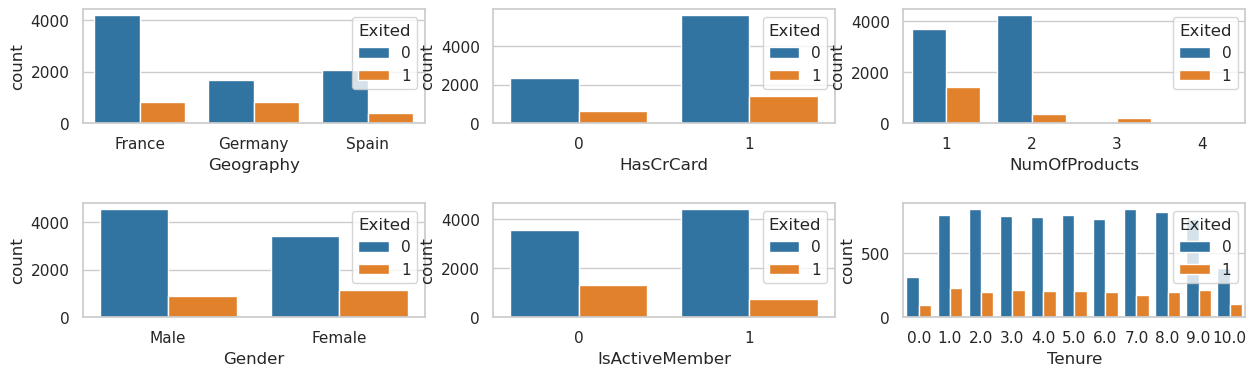

In [12]:
df_clean['Exited'] = df_clean['Exited'].astype(str)

attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
fig, axarr = plt.subplots(2, 3, figsize=(15, 4))
for ind, item in enumerate (attr_list):
    sns.countplot(x = item, hue = 'Exited', data = df_clean, ax = axarr[ind%2][ind//2])
fig.subplots_adjust(hspace=0.7)

### Perform feature engineering 

The following feature engineering generates new attributes based on current attributes.

In [16]:
df_clean["NewTenure"] = df_clean["Tenure"]/df_clean["Age"]
df_clean["NewCreditsScore"] = pd.qcut(df_clean['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

StatementMeta(, c65ed53f-69cb-4e34-b20a-3ecfdbbe3ce4, 30, Finished, Available, Finished)

### Use Data Wrangler to perform one-hot encoding

Following the same instructions discussed earlier to launch Data Wrangler, use the Data Wrangler to perform one-hot encoding. The next cell shows the copied  generated script for one-hot encoding.

<br>

<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows one-hot encoding in the Data Wrangler"> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_selectcolumns_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows selection of columns in the Data Wrangler.">





In [13]:
df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 43, Finished, Available, Finished)

In [14]:
df_clean

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 44, Finished, Available, Finished)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,517,37,5.0,113308.84,1,0,1,31517.16,0,True,False,False,False,True
1,600,37,1.0,142663.46,1,0,1,88669.89,0,True,False,False,False,True
2,739,37,7.0,104960.46,1,0,1,80883.82,0,True,False,False,False,True
3,694,37,10.0,143835.47,1,0,1,33326.71,0,True,False,False,False,True
4,734,37,3.0,80387.81,1,0,1,77272.62,0,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,712,34,1.0,0.00,2,1,1,195052.12,0,True,False,False,False,True
9994,421,34,2.0,0.00,2,1,1,96615.23,0,True,False,False,False,True
9995,630,34,9.0,0.00,2,1,1,114006.35,0,True,False,False,False,True
9996,680,34,9.0,0.00,2,1,1,95686.60,0,True,False,False,False,True


### Create a delta table to generate the Power BI report

In [15]:
table_name = "Curated_Lakehouse.df_clean"
# Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(df_clean) 
sparkDF.write.mode("overwrite").format("delta").option("overwriteSchema", "true").saveAsTable(table_name)
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 45, Finished, Available, Finished)

Spark dataframe saved to delta table: Curated_Lakehouse.df_clean


### Summary of observations from the exploratory data analysis

- Most of the customers are from France comparing to Spain and Germany, while Spain has the lower churn rate comparing to France and Germany.
- Most of the customers have credit cards.
- There are customers whose age and credit score are above 60 and below 400, respectively, but they can't be considered as outliers.
- Very few customers have more than two of the bank's products.
- Customers who aren't active have a higher churn rate.
- Gender and tenure years don't seem to have an impact on customer's decision to close the bank account.

## Step 4: Model training and tracking


With your data in place, you can now define the model. You'll apply Random Forrest and LightGBM models in this notebook. 

Use `scikit-learn` and `lightgbm` to implement the models within a few lines of code. Also use MLfLow and Fabric Autologging to track the experiments.

Here you'll load the delta table from the lakehouse. You may use other delta tables considering the lakehouse as the source.

In [16]:
SEED = 12345
df_clean = spark.table(table_name).toPandas()

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 46, Finished, Available, Finished)

### Generate experiment for tracking and logging the models using MLflow

This section demonstrates how to generate an experiment, specify model and training parameters as well as scoring metrics, train the models, log them, and save the trained models for later use.

In [33]:
import mlflow

# Set up experiment name
EXPERIMENT_NAME = "customer-churn-experiment"  # MLflow experiment name

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 65, Finished, Available, Finished)

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to your workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in your workspace. To learn more about  autologging, see  [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).

### Set experiment and autologging specifications

In [34]:
mlflow.set_experiment(EXPERIMENT_NAME) # Use date stamp to append to experiment
mlflow.autolog(exclusive=False)

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 66, Finished, Available, Finished)

2024/12/02 23:24:52 INFO mlflow.tracking.fluent: Experiment with name 'customer-churn-experiment' does not exist. Creating a new experiment.
2024/12/02 23:24:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/12/02 23:24:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


### Import scikit-learn

In [35]:
# Import the required libraries for model training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 67, Finished, Available, Finished)

### Prepare training and test datasets

In [36]:
y = df_clean["Exited"]
X = df_clean.drop("Exited",axis=1)
# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 68, Finished, Available, Finished)

### Apply SMOTE to the training data to synthesize new samples for the minority class

SMOTE should only be applied to the training dataset. You must leave the test dataset in its original imbalanced distribution in order to get a valid approximation of how the model will perform on the original data, which is representing the situation in production.

In [37]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_train, y_train)
new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 69, Finished, Available, Finished)

2024/12/02 23:25:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ae9dcb6f-cf6c-4a41-a0ee-82934ec86071', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024-12-02:23:25:08,782 WARNING  [tracking_store.py:153] log_inputs not supported
2024/12/02 23:25:09 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/12/02 23:25:09 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/12/02 23:25:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'rfc2_sm' already exists. Creating a new version of this model...
2024/12/02 23:25:15 INF

### Model training

Train the model using Random Forest with maximum depth of four, with four features.

In [38]:
mlflow.sklearn.autolog(registered_model_name='rfc1_sm')  # Register the trained model with autologging
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc1_sm") as run:
    rfc1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc1_sm_run_id, run.info.status))
    # rfc1.fit(X_train,y_train) # imbalanaced training data
    rfc1_sm.fit(X_res, y_res.ravel()) # balanced training data
    rfc1_sm.score(X_test, y_test)
    y_pred = rfc1_sm.predict(X_test)
    cr_rfc1_sm = classification_report(y_test, y_pred)
    cm_rfc1_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc1_sm = roc_auc_score(y_res, rfc1_sm.predict_proba(X_res)[:, 1])

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 70, Finished, Available, Finished)

2024-12-02:23:25:19,442 WARNING  [tracking_store.py:153] log_inputs not supported
2024/12/02 23:25:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'rfc1_sm' already

Train the model using Random Forest with maximum depth of eight, with six features.

In [39]:
mlflow.sklearn.autolog(registered_model_name='rfc2_sm')  # Register the trained model with autologging
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc2_sm") as run:
    rfc2_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc2_sm_run_id, run.info.status))
    # rfc2.fit(X_train,y_train) # imbalanced training data
    rfc2_sm.fit(X_res, y_res.ravel()) # balanced training data
    rfc2_sm.score(X_test, y_test)
    y_pred = rfc2_sm.predict(X_test)
    cr_rfc2_sm = classification_report(y_test, y_pred)
    cm_rfc2_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc2_sm = roc_auc_score(y_res, rfc2_sm.predict_proba(X_res)[:, 1])

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 71, Finished, Available, Finished)

2024-12-02:23:25:32,552 WARNING  [tracking_store.py:153] log_inputs not supported
2024/12/02 23:25:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Registered model 'rfc2_sm' already

Train the model using LightGBM.

### Experiments artifact for tracking model performance

The experiment runs are automatically saved in the experiment artifact that can be found from the workspace. They're named based on the name used for setting the experiment. All of the trained models, their runs, performance metrics and model parameters are logged as can be seen from the experiment page shown in the image below.   

To view your experiments:
1. On the left panel, select your workspace.
1. Find and select the experiment name, in this case _sample-bank-churn-experiment_.

## Step 5: Evaluate and save the final machine learning model


Open the saved experiment from the workspace to select and save the best model.

In [40]:
# Define run_uri to fetch the model
# mlflow client: mlflow.model.url, list model
load_model_rfc1_sm = mlflow.sklearn.load_model(f"runs:/{rfc1_sm_run_id}/model")
load_model_rfc2_sm = mlflow.sklearn.load_model(f"runs:/{rfc2_sm_run_id}/model")

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 72, Finished, Available, Finished)

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 75, Finished, Available, Finished)

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 76, Finished, Available, Finished)

### Assess the performances of the saved models on test dataset

In [41]:
ypred_rfc1_sm = load_model_rfc1_sm.predict(X_test) # Random Forest with max depth of 4 and 4 features
ypred_rfc2_sm = load_model_rfc2_sm.predict(X_test) # Random Forest with max depth of 8 and 6 features

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 73, Finished, Available, Finished)

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
cr1=classification_report(y_test, y_pred=ypred_rfc1_sm)
cr2=classification_report(y_test, y_pred=ypred_rfc2_sm)
print('The Classification Report: (Random Forest with max depth of 4)\n',cr1)
print('The Classification Report: (Random Forest with max depth of 8)\n',cr2)

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 74, Finished, Available, Finished)

The Classification Report: (Random Forest with max depth of 4)
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      1580
           1       0.55      0.58      0.56       420

    accuracy                           0.81      2000
   macro avg       0.72      0.73      0.72      2000
weighted avg       0.82      0.81      0.81      2000

The Classification Report: (Random Forest with max depth of 8)
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1580
           1       0.61      0.59      0.60       420

    accuracy                           0.83      2000
   macro avg       0.75      0.74      0.75      2000
weighted avg       0.83      0.83      0.83      2000



### Save results

Move model prediction results to Power BI Visualization by saving delta frame to lakehouse.

In [43]:
df_pred = X_test.copy()
df_pred['y_test'] = y_test
df_pred['ypred_rfc1_sm'] = ypred_rfc1_sm
df_pred['ypred_rfc2_sm'] =ypred_rfc2_sm
table_name = "Curated_Lakehouse.customer_churn_pred_results"
sparkDF=spark.createDataFrame(df_pred)
sparkDF.write.mode("overwrite").format("delta").option("overwriteSchema", "true").saveAsTable(table_name)
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 77, Finished, Available, Finished)

Spark dataframe saved to delta table: Curated_Lakehouse.customer_churn_pred_results


In [44]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, c6fa776f-ff49-49f0-991e-ce14a5a2c901, 78, Finished, Available, Finished)

Full run cost 4167 seconds.
